In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=4adb09ad08e726a945c683cd8334cf1aa023020795b60e5b88fb2a3b62eb1b9f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchviz import make_dot
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

all_images = np.array([np.array(image) for image, _ in train_dataset])

mean_per_channel = np.mean(all_images, axis=(0, 2, 3))
std_per_channel = np.std(all_images, axis=(0, 2, 3))

print("Mean per channel:", mean_per_channel)
print("Std per channel:", std_per_channel)

# from web values
CIFAR10_TRAIN_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_TRAIN_STD = (0.2023, 0.1994, 0.2010)

cuda


100%|██████████| 170498071/170498071 [00:03<00:00, 44697499.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean per channel: [0.4914009  0.48215896 0.4465308 ]
Std per channel: [0.24703279 0.24348423 0.26158753]


In [3]:
custom_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_channel, std=std_per_channel)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=custom_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=custom_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [4]:
import torch.nn as nn
from skimage.util import view_as_blocks

def extract_patches(images, patch_size):
    batch_size, channels, height, width = images.shape

    num_patches = height // patch_size

    patches = view_as_blocks(images.cpu().numpy(), (1, channels, patch_size, patch_size)).reshape(
        batch_size, num_patches ** 2, channels, patch_size, patch_size
    )

    return torch.tensor(patches).to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-5-7ee87058a67b>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  patched = torch.tensor(extract_patches(one_batch, 8)).cpu()


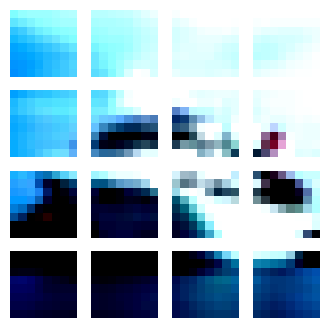

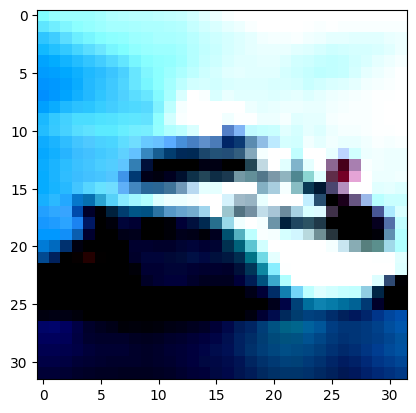

In [5]:
import numpy as np
import matplotlib.pyplot as plt

one_batch = next(iter(train_loader))[0]
patched = torch.tensor(extract_patches(one_batch, 8)).cpu()

for i in range(1):
    fig, axes = plt.subplots(4, 4, figsize=(4,4))
    for j in range(16):
        axes[j//4, j%4].imshow(patched[i,j].permute(1, 2, 0))  # Assuming channel is the last dimension
        axes[j//4, j%4].axis("off")

plt.show()

plt.imshow(one_batch[0].permute(1, 2, 0))

In [7]:
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, embed_size = 256, heads = 8, hidden_dim=512, dropout=0.2):
        super(TransformerBlock, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_size, heads)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)
        self.linear1 = nn.Linear(embed_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, embed_size)
        self.activation = nn.GELU()

    def forward(self, x):
        y = self.layer_norm1(x)
        y, _ = self.multihead_attn(y, y, y)
        x = x + y

        y = self.layer_norm2(x)
        y = self.linear1(y)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.linear2(y)
        y = self.dropout(y)
        x = x + y
        return x

class VisualTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, num_patches=64, emb_size=256, num_heads=8, num_layers=6, mlp_dim=512, dropout=0.2):
        super(VisualTransformer, self).__init__()

        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(patch_size * patch_size * 3, emb_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.norm_token = nn.init.normal_(self.class_token, mean=0, std=0.02)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_size))
        self.positional_embedding.requires_grad = False
        self.dropout = nn.Dropout(dropout)

        self.transformers = nn.Sequential(*[
            TransformerBlock() for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(emb_size)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        x = extract_patches(x, self.patch_size)
        x = x.view(x.size(0), x.size(1), -1)
        x = self.patch_embedding(x)
        class_token = self.norm_token.expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1)
        x += self.positional_embedding
        x = self.dropout(x)

        x = self.transformers(x)

        x = x[:, 0]
        x = self.layer_norm(x)
        x = self.fc(x)
        return x

model = VisualTransformer().to(device)

input_data = next(iter(train_loader))[0]

output = model(input_data)
print("Model Output Shape:", output.shape)

Model Output Shape: torch.Size([64, 10])


In [8]:
print(model.parameters())

<generator object Module.parameters at 0x78e5bcbf5a10>


In [9]:
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("vision_transformer_graph", format="png", cleanup=True)

'vision_transformer_graph.png'

In [10]:
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 256]          12,544
           Dropout-2              [-1, 65, 256]               0
         LayerNorm-3              [-1, 65, 256]             512
MultiheadAttention-4  [[-1, 65, 256], [-1, 2, 2]]               0
         LayerNorm-5              [-1, 65, 256]             512
            Linear-6              [-1, 65, 512]         131,584
              GELU-7              [-1, 65, 512]               0
           Dropout-8              [-1, 65, 512]               0
            Linear-9              [-1, 65, 256]         131,328
          Dropout-10              [-1, 65, 256]               0
 TransformerBlock-11              [-1, 65, 256]               0
        LayerNorm-12              [-1, 65, 256]             512
MultiheadAttention-13  [[-1, 65, 256], [-1, 2, 2]]               0
        LayerNorm-14              

In [11]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        epoch_loss += loss.detach().cpu().item()
        loss.backward()
        optimizer.step()

    scheduler.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/5, Loss: 1820.9882, Accuracy: 0.1009
Epoch 2/5, Loss: 1809.2779, Accuracy: 0.1000
Epoch 3/5, Loss: 1805.4519, Accuracy: 0.1000
Epoch 4/5, Loss: 1803.7370, Accuracy: 0.1000
Epoch 5/5, Loss: 1802.9716, Accuracy: 0.1000
